# 深度学习基础

## 3.特征提取：站在巨人肩膀上


从 VGG16 预训练模型中提取特征

In [35]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## 3.1 快速特征提取

In [36]:
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

train_dir = 'data/train'

validation_dir = 'data/validation'
test_dir = 'data/test'


datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
            directory,
            target_size=(150, 150),
            batch_size=batch_size,
            class_mode='binary')

    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [37]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [38]:
# 目前，提取的特征形状为 (samples, 4, 4, 512)。
# 我们要将其输入到密集连接分类器中， 
# 因此，必须先将其形状展平为 (samples, 8192)。
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [39]:
from keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,
                    train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5703 - acc: 0.6950 - val_loss: 0.4347 - val_acc: 0.8330
Epoch 2/30
2000/2000 [==============================] - 1s 621us/step - loss: 0.4198 - acc: 0.8140 - val_loss: 0.3733 - val_acc: 0.8630
Epoch 3/30
2000/2000 [==============================] - 1s 611us/step - loss: 0.3645 - acc: 0.8485 - val_loss: 0.3303 - val_acc: 0.8690
Epoch 4/30
2000/2000 [==============================] - 1s 616us/step - loss: 0.3105 - acc: 0.8700 - val_loss: 0.3086 - val_acc: 0.8760
Epoch 5/30
2000/2000 [==============================] - 1s 607us/step - loss: 0.2998 - acc: 0.8730 - val_loss: 0.2952 - val_acc: 0.8800
Epoch 6/30
2000/2000 [==============================] - 1s 603us/step - loss: 0.2672 - acc: 0.8975 - val_loss: 0.2843 - val_acc: 0.8840
Epoch 7/30
2000/2000 [==============================] - 1s 716us/step - loss: 0.2468 - acc: 0.9015 - val_loss: 0.2694 - val_acc: 0.8860
Ep

In [40]:
model.save('cats_and_dogs_small_3.h5')

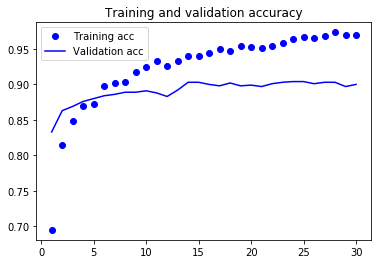

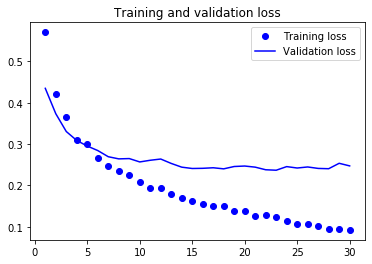

In [41]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 3.2 使用数据增强的特征提取

In [42]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [43]:
conv_base.trainable = False
model.trainable_weights

[<tf.Variable 'dense_9/kernel:0' shape=(8192, 256) dtype=float32_ref>,
 <tf.Variable 'dense_9/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'dense_10/kernel:0' shape=(256, 1) dtype=float32_ref>,
 <tf.Variable 'dense_10/bias:0' shape=(1,) dtype=float32_ref>]

In [44]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [45]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [46]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [47]:
history = model.fit(
        train_generator,
        steps_per_epoch=50,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=50)

Epoch 1/30
50/50 [==============================] - 237s 5s/step - loss: 0.6490 - acc: 0.6120 - val_loss: 0.5407 - val_acc: 0.7670
Epoch 2/30
50/50 [==============================] - 251s 5s/step - loss: 0.5575 - acc: 0.7570 - val_loss: 0.4561 - val_acc: 0.8250
Epoch 3/30
50/50 [==============================] - 261s 5s/step - loss: 0.5102 - acc: 0.7620 - val_loss: 0.3957 - val_acc: 0.8490
Epoch 4/30
50/50 [==============================] - 261s 5s/step - loss: 0.4560 - acc: 0.8100 - val_loss: 0.3751 - val_acc: 0.8540
Epoch 5/30
50/50 [==============================] - 252s 5s/step - loss: 0.4434 - acc: 0.8060 - val_loss: 0.3386 - val_acc: 0.8650
Epoch 6/30
50/50 [==============================] - 259s 5s/step - loss: 0.4383 - acc: 0.7980 - val_loss: 0.3292 - val_acc: 0.8660
Epoch 7/30
50/50 [==============================] - 226s 5s/step - loss: 0.4055 - acc: 0.8290 - val_loss: 0.3146 - val_acc: 0.8690
Epoch 8/30
50/50 [==============================] - 225s 5s/step - loss: 0.3922 - a

In [48]:
model.save('cats_and_dogs_small_4.h5')

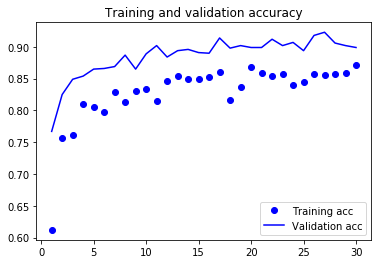

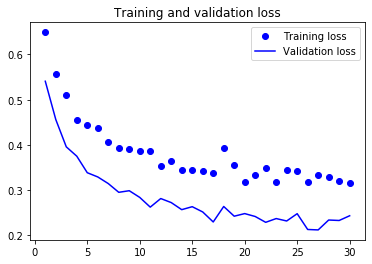

In [49]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()